In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

In [2]:
import tensorflow as tf
from copy import deepcopy

In [30]:
# y = tf.random.normal(shape=(10,3))
# mu = tf.random.normal(shape=(2*3,))

# mu2 = tf.reshape(mu, shape=(2,3))


# print(y)
# print(mu2)



N = 5
d = 3
k = 2

y = np.arange(N*d).reshape((N,d))
m = np.arange(k*d).reshape((k,d))

print(np.sum((y[:,np.newaxis,:]-m), axis=-1).shape)




(5, 2)


In [3]:
tf.__version__

'2.2.0'

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.executing_eagerly()

True

In [6]:
# Example presented in the PRML book
def create_book_example(n=1000):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,1)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,1)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)    
    return X, y, x_test

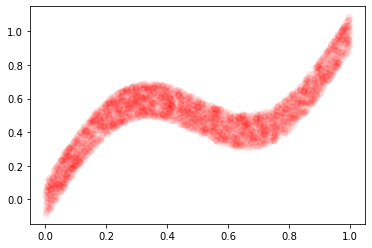

In [7]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=4000)
plt.plot(X, y, 'ro', alpha=0.04)
plt.show()

In [8]:
# Build model
def get_model(h=16, lr=0.001):
    input = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Dense(h, activation='tanh')(input)
    x = tf.keras.layers.Dense(1, activation=None)(x)

    model = tf.keras.models.Model(input, x)
    # Use Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='mse')
#     model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [ ]:

# Load and train the network
model = get_model(h=50)
epochs=1000
# Change verbosity (e.g verbose=1) to view the training progress
history = model.fit(X, y, epochs=epochs, verbose=0)
print('Final loss: {}'.format(history.history['loss'][-1]))
# Plot the loss history
plt.plot(range(epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training')
plt.show()

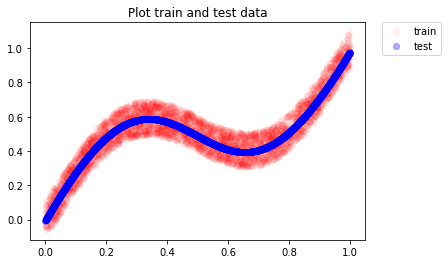

In [11]:
# Predict the target values for test data and
# plot along with training data
y_test = model.predict(x_test)
plt.plot(X, y, 'ro', alpha=0.05, label='train')
plt.plot(x_test, y_test, 'bo', alpha=0.3, label='test')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Plot train and test data')
plt.show()

# Inverse Problem

(4000, 1) (4000, 1)
0.05202391743659973


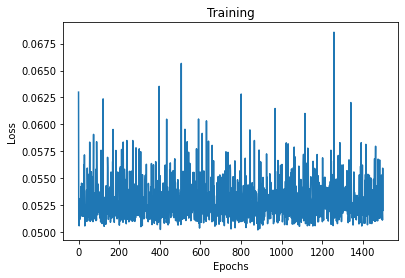

In [12]:
# print data shape
print(X.shape, y.shape)

# Deepcopy is not required in this case
# (its more of a habit for me)
flipped_x = deepcopy(y)
flipped_y = deepcopy(X)

# load and train the model
model = get_model(lr=0.09)

# Train the model for large number of epochs
epochs=1500
history = model.fit(flipped_x, flipped_y, epochs=epochs, verbose=0)
print(history.history['loss'][-1])
plt.plot(range(epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training')
plt.show()

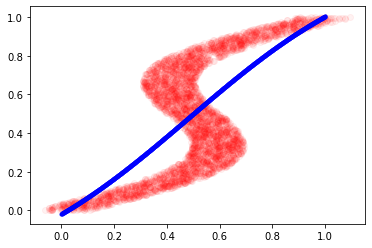

In [13]:
# epochs 500
x_test_inv = np.linspace(0., 1., 4000).reshape(-1, 1)
y_test_inv = model.predict(x_test_inv)

plt.plot(y, X, 'ro', alpha=0.05)
plt.plot(x_test_inv, y_test_inv, 'b.', alpha=0.3)
plt.show()

# Mixture Model Network

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           100         input_7[0][0]                    
__________________________________________________________________________________________________
baselayer2 (Dense)              (None, 50)           2550        baselayer[0][0]                  
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 26)           1326        baselayer2[0][0]                 
____________________________________________________________________________________________

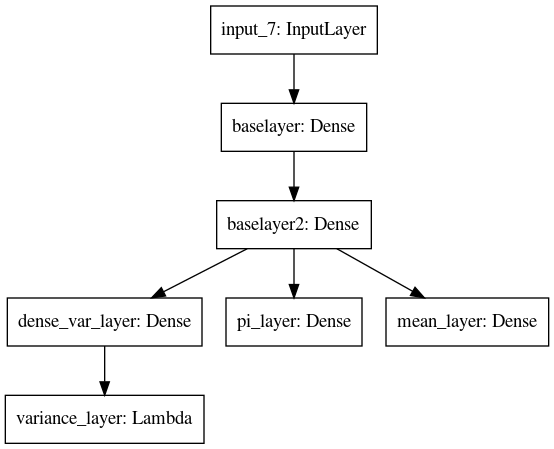

In [36]:
# In our toy example, we have single input feature
l = 1
# Number of gaussians to represent the multimodal distribution
k = 26

# Network
inp       = tf.keras.Input(shape=(l,))
layer     = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(inp)
layer     = tf.keras.layers.Dense(50, activation='tanh', name='baselayer2')(layer)
mu        = tf.keras.layers.Dense((l * k), activation=None, name='mean_layer')(layer)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var       = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
pi        = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)


model = tf.keras.models.Model(inp, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()
tf.keras.utils.plot_model(model)

In [22]:
# Take a note how easy it is to write the loss function in 
# new tensorflow eager mode (debugging the function becomes intuitive too)

def calc_pdf(y, mu, var):
    """Calculate component density"""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value


def mdn_loss(y_true, pi, mu, var):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
    out = calc_pdf(y_true, mu, var)
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

In [23]:
# calc_pdf(3.0, 0.0, 1.0).numpy()
calc_pdf(np.array([3.0]), np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3])).numpy()

array([0.00443185, 0.03977444, 0.06695205])

In [24]:
# Numpy version
def pdf_np(y, mu, var):
    n = np.exp((-(y-mu)**2)/(2*var))
    d = np.sqrt(2 * np.pi * var)
    return n/d
print('Numpy version: ')
pdf_np(3.0, np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3]))

Numpy version: 


array([0.00443185, 0.03977444, 0.06695205])

In [25]:
loss_value = mdn_loss(
    np.array([3.0, 1.1]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]).reshape(2,-1).astype('float64'), 
    np.array([[0.0, 0.1, 0.2], [0.0, 0.1, 0.2]]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 2.2, 3.3], [1.0, 2.2, 3.3]]).reshape(2,-1).astype('float64')
).numpy()

assert np.isclose(loss_value, 3.4714, atol=1e-5), 'MDN loss incorrect'

In [26]:
# Use Dataset API to load numpy data (load, shuffle, set batch size)
N = flipped_x.shape[0]
dataset = tf.data.Dataset \
    .from_tensor_slices((flipped_x, flipped_y)) \
    .shuffle(N).batch(N)

In [27]:
@tf.function
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [29]:
losses = []
EPOCHS = 6000
print_every = int(0.1 * EPOCHS)

# Define model and optimizer
model = tf.keras.models.Model(inp, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))

Print every 600 epochs
Epoch 0/6000: loss 1.0974445343017578
Epoch 600/6000: loss -0.8554112315177917
Epoch 1200/6000: loss -0.9857993721961975
Epoch 1800/6000: loss -1.0156540870666504
Epoch 2400/6000: loss -1.0261667966842651
Epoch 3000/6000: loss -1.0320913791656494
Epoch 3600/6000: loss -1.0357398986816406
Epoch 4200/6000: loss -1.0392802953720093
Epoch 4800/6000: loss -1.0425664186477661
Epoch 5400/6000: loss -1.0460307598114014


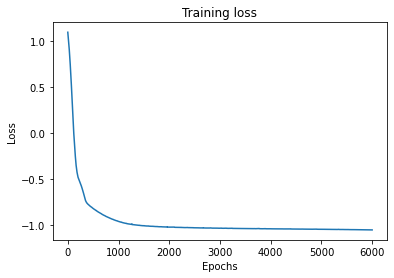

In [30]:
# Let's plot the training loss
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

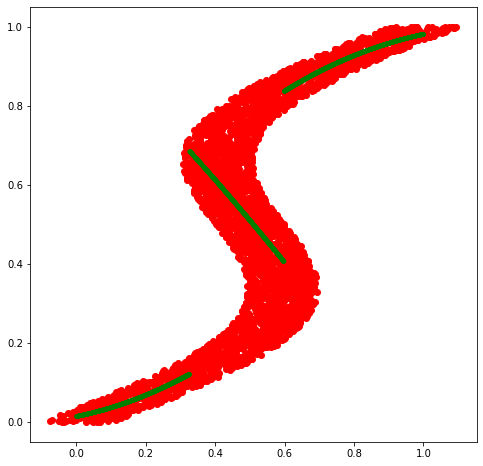

In [32]:
def approx_conditional_mode(pi, var, mu):
    """Approx conditional mode
    Because the conditional mode for MDN does not have simple analytical
    solution, an alternative is to take mean of most probable component 
    at each value of x (PRML, page 277)
    """
    n, k = pi.shape
    out = np.zeros((n, l))
    # Get the index of max pi value for each row
    max_component = tf.argmax(pi, axis=1)
    for i in range(n):
        # The mean value for this index will be used
        mc = max_component[i].numpy()
        for j in range(l):
            out[i, j] = mu[i, mc*(l+j)]
    return out


# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)
pi_vals.shape, mu_vals.shape, var_vals.shape

# Get mean of max(mixing coefficient) of each row
preds = approx_conditional_mode(pi_vals, var_vals, mu_vals)

# Plot along with training data
fig = plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro')
plt.plot(x_test, preds, 'g.')
# plt.plot(flipped_x, preds2, 'b.')
plt.show()

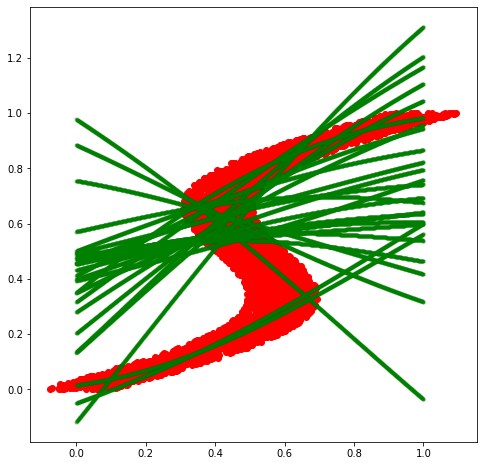

In [33]:
# Display all mean values
fig = plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro')
plt.plot(x_test, mu_vals, 'g.', alpha=0.1)
plt.show()

In [34]:
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 10)

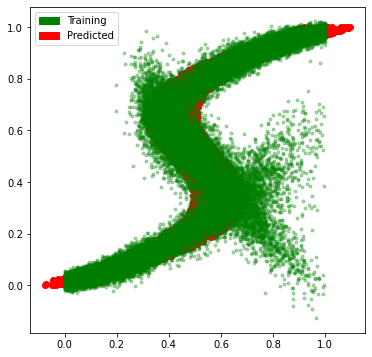

In [35]:
# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(x_test, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]
    
plt.legend(handles=patches)
plt.show()

In [43]:
import tensorflow as tf
from tensorflow import keras


class GaussianMDN(keras.Model):

    def __init__(self,
                 n_mixtures,
                 input_dim,
                 layer_units,
                 layer_activations=None
                 ):

        self.n_mixtures  = n_mixtures
        self.input_dim   = input_dim
        self.layer_units = layer_units

        if layer_activations is None:
            self.layer_activations = [ 'relu' for _ in range(len(layer_units)) ]
        
        elif isinstance(layer_activations, list):
            if len(layer_activations) != len(layer_units): raise ValueError
            self.layer_activations = layer_activations

        elif isinstance(layer_activations, str):
            self.layer_activations = [layer_activations for _ in range(len(layer_units))]

        else:
            raise ValueError

            

        inp = keras.Input(shape=(self.input_dim,), name='mdn_input')
        prev_tensor = inp
        for i, units, activation in zip(range(len(self.layer_units)), self.layer_units, self.layer_activations):
            layer       = keras.layers.Dense(units, activation=activation, name=f"mdn_dense{i}")(prev_tensor)
            prev_tensor = layer

        mu   = keras.layers.Dense(self.n_mixtures*self.input_dim, activation=None, name='mdn_mean')(prev_tensor)
        var  = keras.layers.Dense(self.n_mixtures, activation=keras.activations.exponential, name='mdn_var')(prev_tensor)
        pi   = keras.layers.Dense(self.n_mixtures, activation='softmax', name='mdn_pi')(prev_tensor)

    
        super(keras.Model, self).__init__(inp, [pi, mu, var])

        self.pi  = pi
        self.mu  = mu
        self.var = var



if __name__ == '__main__':
    model = GaussianMDN(3, 1, [10,20,30], 'relu')